In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import numpy as np
from lyft_dataset_sdk.lyftdataset import LyftDataset
import matplotlib.pyplot as plt
from prepare_lyft_data import parse_train_csv,get_pc_in_image_fov,parse_string_to_box

In [90]:
from prepare_lyft_data_v2 import load_train_data
from test_data_loader import load_test_data

In [91]:
level5data=load_test_data()

number of scenes: 218


In [92]:
import pickle

In [93]:
pred_file="/Users/kanhua/Dropbox/Programming/lyft-3d-main/train_val_pred.csv"

In [94]:
import pandas as pd
val_df=pd.read_csv(pred_file,index_col="Id")

In [95]:
val_df.head()

,PredictionString
Id,
24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8,0.47073620557785034 1019.8469574329433 1737.60...
c2ba18e4414ce9038ad52efab44e1a0a211ff1e6b297a632805000510756174d,0.5573983192443848 1016.1520827421479 1693.274...
57c823209ea714288c2f56a3bf2510a9f02db43310ee3631a7d678b191645e12,0.6862908601760864 1007.1091951021189 1714.228...
29fd7d429450b8ac7478323ef9d5eede87fd184d74c3c36cd2e2853281043459,0.9502612352371216 973.0266942269146 1695.0624...
282b5aec05ed14275e0a7fb3f785c4cb4ad096a0faee0c5bf1d42122c646d194,0.6740049719810486 1001.5903604278955 1763.516...


In [96]:
data_idx=2
sample_token=val_df.index[data_idx]
boxes_str=val_df.loc[sample_token,'PredictionString']

In [97]:
boxes=parse_string_to_box(boxes_str)

In [98]:
sample_record=level5data.get("sample",sample_token)

KeyError: '57c823209ea714288c2f56a3bf2510a9f02db43310ee3631a7d678b191645e12'

In [ ]:
from skimage.io import imread

In [99]:
from prepare_lyft_data import transform_box_from_world_to_sensor_coordinates,get_train_data_sample_token_and_box

In [100]:
lidar_top_token=sample_record['data']['LIDAR_TOP']
lidar_path=level5data.get_sample_data_path(lidar_top_token)

In [101]:
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud

In [102]:
lpc=LidarPointCloud.from_file(lidar_path)

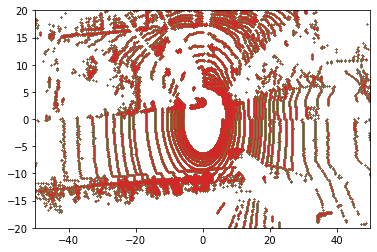

In [103]:
fig,ax=plt.subplots()
for pred_box in boxes:
    box_in_lidar_coord=transform_box_from_world_to_sensor_coordinates(pred_box,lidar_top_token,level5data)

    pts=lpc.points
    ax.scatter(pts[0,:],pts[1,:],s=0.1)
    ax.set_xlim([-50,50])
    ax.set_ylim([-20,20])
    view_mtx=np.eye(2)
    box_in_lidar_coord.render(ax,view=view_mtx)

In [104]:
sample_record['data']

{'CAM_FRONT_LEFT': '6cbd09e5aedd58b03287353c5c84df164e8c07edefd7347577f72caf847079a7',
 'CAM_BACK': '2d266b7fcafcee237324e2dfacbc0f9b7147595ad3a81a666240dcca81735c07',
 'LIDAR_TOP': '82b4f9dbd4e0e2fdb3628e83a611cf5c123a6504a45d6004f9604248c76c91bb',
 'CAM_BACK_LEFT': '6ec309b75066490f5729b97926ba35beb6fc2efee70fabc7f64e3935fc1ccef4',
 'CAM_FRONT_ZOOMED': 'c204285a0889f24bca95a9518234b0e854e4e97d1eee1e0dfc8d6d0413138f61',
 'CAM_FRONT': '0108675fec3d5f9d59657782e73807929a7f318a4367c699e06997719c1f0659',
 'CAM_BACK_RIGHT': '4e4395dc54641dff7c9eb0503c16e91a1589f985b878cfcf39977c992fb2e544',
 'CAM_FRONT_RIGHT': '481291a0fdfee2710172fc27da3522f8f5db13241d83240b5534c06a2b17d399'}

In [105]:
camera_token=sample_record['data']['CAM_FRONT_LEFT']

In [106]:
camera_image_path,_,cam_intrinsic=level5data.get_sample_data(camera_token)

(1024, 0)

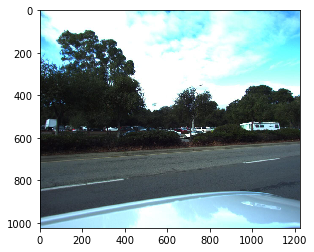

In [107]:
image_array=imread(camera_image_path)
fig,ax=plt.subplots()
ax.imshow(image_array)
for pred_box in boxes:
    if pred_box.score > -2:
        box_in_camera_coord=transform_box_from_world_to_sensor_coordinates(pred_box,camera_token,level5data)
        if box_in_camera_coord.center[2]>0:
            print(box_in_camera_coord.center[2])
            box_in_camera_coord.render(ax,view=cam_intrinsic,normalize=True)
        #print(pred_box.center)
        

ax.set_xlim([0,image_array.shape[1]])
ax.set_ylim([image_array.shape[0],0])

## Show ground truth data

In [108]:
level5data.render_sample(sample_token=sample_token,out_path="./doc_figs/data_demo.png")

KeyError: '57c823209ea714288c2f56a3bf2510a9f02db43310ee3631a7d678b191645e12'

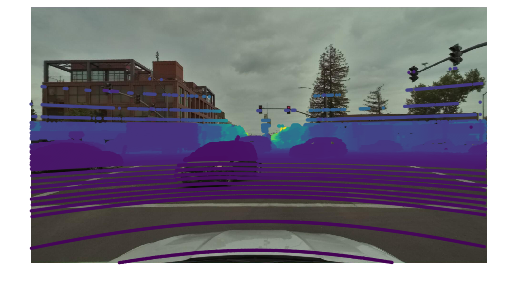

In [21]:
level5data.render_pointcloud_in_image(sample_token)

In [22]:
pred_obj.iloc[15,:]

NameError: name 'pred_obj' is not defined

In [ ]:
pred_obj.iloc[14,:]

In [ ]:
pred_obj.iloc[17,:]

In [ ]:
from object_classifier import TLClassifier
from vis_util import draw_bounding_boxes_on_image_array,draw_bounding_box_on_image_array

In [ ]:
tlc=TLClassifier()

In [ ]:
det_box=tlc.detect_multi_object(image_array,score_threshold=[0.6,0.6,0.6],rearrange_to_pointnet_convention=False)
det_box

In [ ]:
image_to_draw=np.copy(image_array)
det_box=det_box[:,0:4]
draw_bounding_boxes_on_image_array(image_to_draw,det_box)
plt.imshow(image_to_draw)

In [ ]:
det_box=tlc.detect_multi_object(image_array,score_threshold=[0.6,0.6,0.6],rearrange_to_pointnet_convention=True)
mask, pc_3d, pc_2d, lpc, img=get_pc_in_image_fov(lidar_top_token,'CAM_FRONT',level5testdata,bounding_box=det_box[1,0:4])

In [ ]:
pc_2d.shape

In [ ]:
fig,ax=plt.subplots()
ax.imshow(img)
ax.scatter(pc_2d[0,:],pc_2d[1,:])

In [ ]:
image_array.shape